In [36]:
import cv2
import os
import numpy as np
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from glob import glob
from einops import rearrange
from typing import Union, List, Tuple

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

from data import rand_perlin_2d_np
from utils import torch_seed

In [37]:
cfg = OmegaConf.load('./configs.yaml')
cfg.DATASET.target = 'capsule'

In [38]:
class MemSegDataset(Dataset):
    def __init__(
        self, datadir: str, target: str, train: bool, to_memory: bool = False,
        resize: Tuple[int, int] = (224,224),
        texture_source_dir: str = None, structure_grid_size: str = 8,
        transparency_range: List[float] = [0.15, 1.],
        perlin_scale: int = 6, min_perlin_scale: int = 0, perlin_noise_threshold: float = 0.5,
    ):
        # mode
        self.train = train 
        self.to_memory = to_memory

        # load image file list
        self.datadir = datadir
        self.target = target
        self.file_list = glob(os.path.join(self.datadir, self.target, 'train/*/*' if train else 'test/*/*'))
        
        # load texture image file list
        if texture_source_dir:
            self.texture_source_file_list = glob(os.path.join(texture_source_dir,'*/*'))
            
        # synthetic anomaly
        if train:
            self.transparency_range = transparency_range
            self.perlin_scale = perlin_scale
            self.min_perlin_scale = min_perlin_scale
            self.perlin_noise_threshold = perlin_noise_threshold
            self.structure_grid_size = structure_grid_size
        
        # transform ndarray into tensor
        self.resize = resize
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean = (0.485, 0.456, 0.406),
                std  = (0.229, 0.224, 0.225)
            )
        ])

        # sythetic anomaly switch
        self.anomaly_switch = False
        
    def __getitem__(self, idx):
        
        file_path = self.file_list[idx]
        
        # image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(self.resize[1], self.resize[0]))
        
        # target
        target = 0 if 'good' in self.file_list[idx] else 1
        
        # mask
        if 'good' in file_path:
            mask = np.zeros(self.resize, dtype=np.float32)
        else:
            mask = cv2.imread(
                file_path.replace('test','ground_truth').replace('.png','_mask.png'), 
                cv2.IMREAD_GRAYSCALE
            )
            mask = cv2.resize(mask, dsize=self.resize).astype(np.bool).astype(np.int)

        ## anomaly source
        if not self.to_memory and self.train:
            if self.anomaly_switch:
                img, mask = self.generate_anomaly(img=img)
                target = 1
                self.anomaly_switch = False
            else:        
                self.anomaly_switch = True
            
        # convert ndarray into tensor
        img = self.transform(img)
        mask = torch.Tensor(mask).to(torch.int64)
        
        return img, mask, target
        
        
    def rand_augment(self):
        '''
        Choose a random augmentaiton to porperly augment the image as they mentioned in the paper
        '''
        augmenters = [
            iaa.GammaContrast((0.5,2.0),per_channel=True),
            iaa.MultiplyAndAddToBrightness(mul=(0.8,1.2),add=(-30,30)),
            iaa.pillike.EnhanceSharpness(),
            iaa.AddToHueAndSaturation((-50,50),per_channel=True),
            iaa.Solarize(0.5, threshold=(32,128)),
            iaa.Posterize(),
            iaa.Invert(),
            iaa.pillike.Autocontrast(),
            iaa.pillike.Equalize(),
            iaa.Affine(rotate=(-45, 45))
        ]

        aug_idx = np.random.choice(np.arange(len(augmenters)), 3, replace=False)
        aug = iaa.Sequential([
            augmenters[aug_idx[0]],
            augmenters[aug_idx[1]],
            augmenters[aug_idx[2]]
        ])
        
        return aug
        
    def generate_anomaly(self, img: np.ndarray) -> List[np.ndarray]:
        '''
        step 1. generate mask
            - target foreground mask
            - perlin noise mask
            
        step 2. generate texture or structure anomaly
            - texture: load DTD
            - structure: we first perform random adjustment of mirror symmetry, rotation, brightness, saturation, 
            and hue on the input image  𝐼 . Then the preliminary processed image is uniformly divided into a 4×8 grid 
            and randomly arranged to obtain the disordered image  𝐼 
            
        step 3. blending image and anomaly source
        '''
        
        # step 1. generate mask
        
        ## target foreground mask
        target_foreground_mask = self.generate_target_foreground_mask(img=img)
        
        ## perlin noise mask
        perlin_noise_mask = self.generate_perlin_noise_mask()
        
        ## mask
        mask = perlin_noise_mask * target_foreground_mask
        mask_expanded = np.expand_dims(mask, axis=2)
        
        # step 2. generate texture or structure anomaly
        
        ## anomaly source
        anomaly_source_img = self.anomaly_source(img=img)
        
        ## mask anomaly parts
        factor = np.random.uniform(*self.transparency_range, size=1)[0]
        anomaly_source_img = factor * (mask_expanded * anomaly_source_img) + (1 - factor) * (mask_expanded * img)
        
        # step 3. blending image and anomaly source
        anomaly_source_img = ((- mask_expanded + 1) * img) + anomaly_source_img
        
        return (anomaly_source_img.astype(np.uint8), mask)
    
    def generate_target_foreground_mask(self, img: np.ndarray) -> np.ndarray:
        # convert RGB into GRAY scale
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # generate binary mask of gray scale image
        _, target_background_mask = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        target_background_mask = target_background_mask.astype(np.bool).astype(np.int)

        # invert mask for foreground mask
        target_foreground_mask = -(target_background_mask - 1)
        
        return target_foreground_mask
    
    def generate_perlin_noise_mask(self) -> np.ndarray:
        # define perlin noise scale
        perlin_scalex = 2 ** (torch.randint(self.min_perlin_scale, self.perlin_scale, (1,)).numpy()[0])
        perlin_scaley = 2 ** (torch.randint(self.min_perlin_scale, self.perlin_scale, (1,)).numpy()[0])

        # generate perlin noise
        perlin_noise = rand_perlin_2d_np((self.resize[0], self.resize[1]), (perlin_scalex, perlin_scaley))
        
        # apply affine transform
        rot = iaa.Affine(rotate=(-90, 90))
        perlin_noise = rot(image=perlin_noise)
        
        # make a mask by applying threshold
        mask_noise = np.where(
            perlin_noise > self.perlin_noise_threshold, 
            np.ones_like(perlin_noise), 
            np.zeros_like(perlin_noise)
        )
        
        return mask_noise
    
    def anomaly_source(self, img: np.ndarray) -> np.ndarray:
        p = np.random.uniform()
        if p < 0.5:
            # TODO: None texture_source_file_list
            anomaly_source_img = self._texture_source()
        else:
            anomaly_source_img = self._structure_source(img=img)
            
        return anomaly_source_img
        
    def _texture_source(self) -> np.ndarray:
        idx = np.random.choice(len(self.texture_source_file_list))
        texture_source_img = cv2.imread(self.texture_source_file_list[idx])
        texture_source_img = cv2.cvtColor(texture_source_img, cv2.COLOR_BGR2RGB)
        texture_source_img = cv2.resize(texture_source_img, dsize=self.resize).astype(np.float32)
        
        return texture_source_img
        
    def _structure_source(self, img: np.ndarray) -> np.ndarray:
        structure_source_img = self.rand_augment()(image=img)
        
        assert self.resize[0] % self.structure_grid_size == 0, 'structure should be devided by grid size accurately'
        grid_w = self.resize[0] // self.structure_grid_size
        grid_h = self.resize[1] // self.structure_grid_size
        
        structure_source_img = rearrange(
            tensor  = structure_source_img, 
            pattern = '(h gh) (w gw) c -> (h w) gw gh c',
            gw      = grid_w, 
            gh      = grid_h
        )
        disordered_idx = np.arange(structure_source_img.shape[0])
        np.random.shuffle(disordered_idx)

        structure_source_img = rearrange(
            tensor  = structure_source_img[disordered_idx], 
            pattern = '(h w) gw gh c -> (h gh) (w gw) c',
            h       = self.structure_grid_size,
            w       = self.structure_grid_size
        ).astype(np.float32)
        
        return structure_source_img
        
    def __len__(self):
        return len(self.file_list)

# Example

In [39]:
trainset = MemSegDataset(
    datadir                = cfg['DATASET']['datadir'],
    target                 = cfg['DATASET']['target'], 
    train                  = True,
    resize                 = cfg['DATASET']['resize'],
    texture_source_dir     = cfg['DATASET']['texture_source_dir'],
    structure_grid_size    = cfg['DATASET']['structure_grid_size'],
    transparency_range     = cfg['DATASET']['transparency_range'],
    perlin_scale           = cfg['DATASET']['perlin_scale'], 
    min_perlin_scale       = cfg['DATASET']['min_perlin_scale'], 
    perlin_noise_threshold = cfg['DATASET']['perlin_noise_threshold']
)

In [40]:
def minmax_scaling(img):
    '''
    The function first normalizes the pixel values to the [0, 1] range using min-max scaling.
    It then scales these normalized values to the [0, 255] range.
     it converts the pixel values to torch.uint8 type to match the expected data type for image tensors.
    '''
    return (((img - img.min()) / (img.max() - img.min())) * 255).to(torch.uint8)

Text(0.5, 1.0, 'mask')

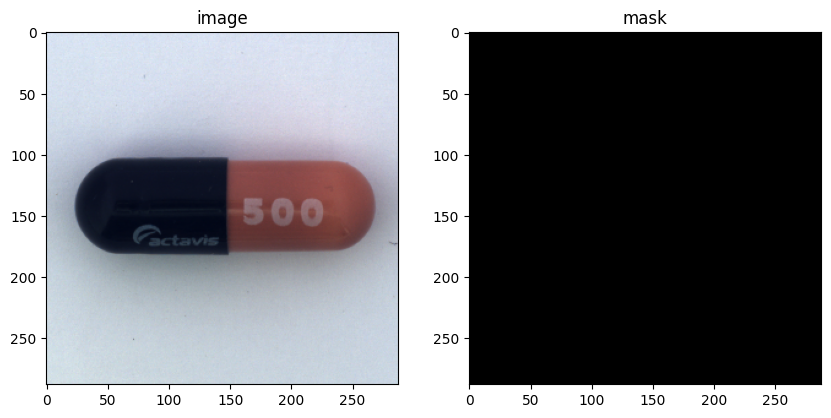

In [41]:
img, mask, target = trainset[0]
# The iamge has shape of (288,,288,3) because you have set the resizing to 288 by 288
# these are good images
fig, ax = plt.subplots(1,2,figsize=(10,15))
ax[0].imshow(minmax_scaling(img.permute(1,2,0)))
ax[0].set_title('image')
ax[1].imshow(minmax_scaling(mask), cmap='gray')
ax[1].set_title('mask')

# Loader Image

In [42]:
os.listdir(cfg['DATASET']['datadir'])

['bottle',
 'cable',
 'capsule',
 'carpet',
 'grid',
 'hazelnut',
 'leather',
 'license.txt',
 'metal_nut',
 'pill',
 'readme.txt',
 'screw',
 'tile',
 'toothbrush',
 'transistor',
 'wood',
 'zipper']

In [43]:
train_file_list = glob(os.path.join(cfg['DATASET']['datadir'], cfg['DATASET']['target'], 'train/*/*'))

In [73]:
train_file_list

['D:\\datasets\\mvtec\\capsule\\train\\good\\000.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\001.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\002.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\003.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\004.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\005.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\006.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\007.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\008.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\009.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\010.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\011.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\012.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\013.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\014.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\015.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\016.png',
 'D:\\datasets\\mvtec\\capsule\\train\\good\\017.png',
 'D:\\data

In [74]:
img = cv2.imread(train_file_list[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)# converted to RGB
print(img.shape)

(1000, 1000, 3)


In [75]:
img = cv2.resize(img, dsize=(cfg['DATASET']['resize'][1], cfg['DATASET']['resize'][0]))
img.shape

(288, 288, 3)

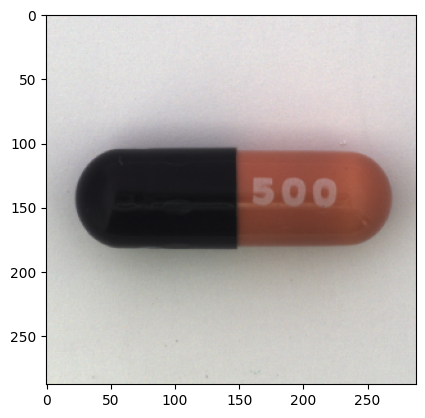

In [76]:
plt.imshow(img)

# Generate Synthetic Anomaly Process
1. generate mask 
    - target foreground mask
    - perlin noise mask
2. generate texture or structure anomaly
    - texture: load DTD
    - structure: we first perform random adjustment of mirror symmetry, rotation, brightness, saturation, and hue on the input image $I$. Then the preliminary processed image is uniformly divided into a 4×8 grid and randomly arranged to obtain the disordered image $I$
3. blending

![image](https://user-images.githubusercontent.com/37654013/198633289-cb14e5b4-1f55-4802-a880-720f8209431e.png)

# Step 1. Generate Mask

## target foreground

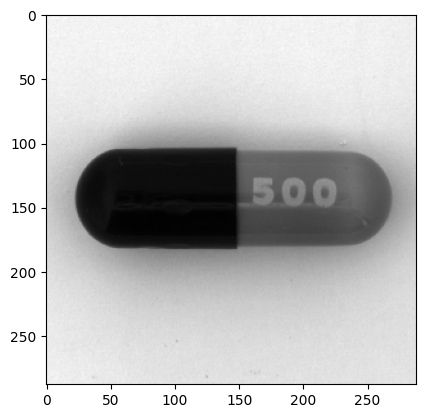

In [77]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert to GRAY scale 
plt.imshow(img_gray, cmap='gray')

In [78]:
_, mask_target_background = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
'''
* cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU): This applies a binary thresholding operation to img_gray.
The cv2.THRESH_BINARY flag specifies that pixels above the
threshold value will be set to the maximum value (255) and pixels below the threshold will be set to 0.
cv2.THRESH_OTSU: This flag automatically calculates the optimal threshold value using Otsu's method. 
In this case, the value 100 serves as a starting point or lower bound,
but Otsu's method will adjust it if necessary.
* The calculated threshold value (not used here).
* mask_target_background: The binary mask image where the background pixels are white (255) and the rest are black (0).

'''
mask_target_background = mask_target_background.astype(np.bool_).astype(int)
'''
Converts the mask to boolean values (True for non-zero values and False for zero values).
.astype(int): Converts the boolean values to integers (1 for True and 0 for False).
'''
mask_target_foreground = -(mask_target_background - 1)
# . Create Foreground Mask from Background Mask
#  This effectively flips the mask to create a foreground mask where the foreground areas are marked as 1 and the background areas are marked as 0.

Text(0.5, 1.0, 'Foreground')

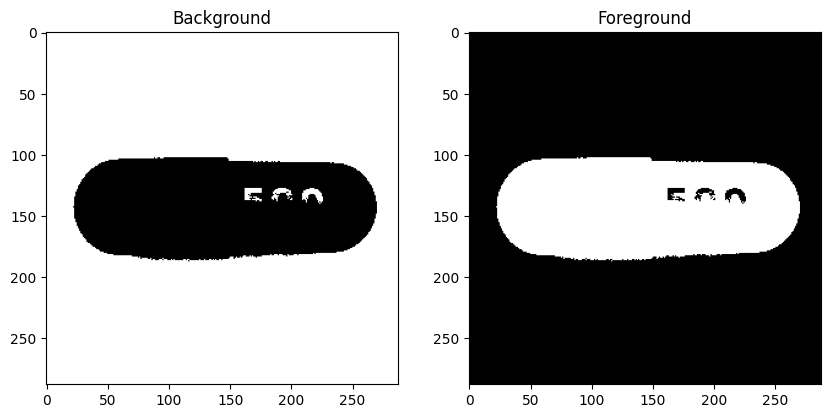

In [79]:
fig, ax = plt.subplots(1,2, figsize=(10,15))
ax[0].imshow(mask_target_background, cmap='gray')
ax[0].set_title('Background')
# THis is the one coming out of the cv2 thresholding method 
ax[1].imshow(mask_target_foreground, cmap='gray')
ax[1].set_title('Foreground')

## Perlin noise

In [101]:
perlin_scale = 6
min_perlin_scale = 0

In [106]:
torch.randint(min_perlin_scale, perlin_scale, (1,)).numpy()[0]

5

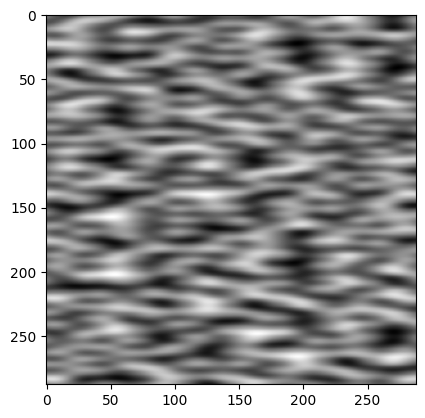

In [100]:
torch_seed(10)
# torch.randint(min_perlin_scale, perlin_scale, (1,)) gives you valuees between min perlin scale ot perlin scale
perlin_scalex =2**(torch.randint(min_perlin_scale, perlin_scale,(1,)).numpy()[0])
perlin_scaley = 2 ** (torch.randint(min_perlin_scale, perlin_scale, (1,)).numpy()[0])

perlin_noise = rand_perlin_2d_np(cfg['DATASET']['resize'], (perlin_scalex, perlin_scaley))

plt.imshow(perlin_noise, cmap='gray')

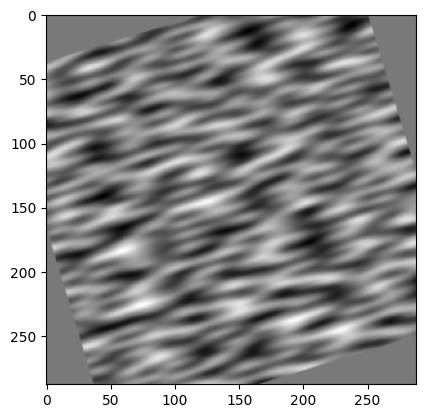

In [92]:
rot = iaa.Affine(rotate=(-90, 90))
perlin_noise = rot(image=perlin_noise)

plt.imshow(perlin_noise, cmap='gray')

In [107]:
print('max: ',perlin_noise.max())
print('min: ',perlin_noise.min())

max:  0.9046464503680988
min:  -0.8157546531016832


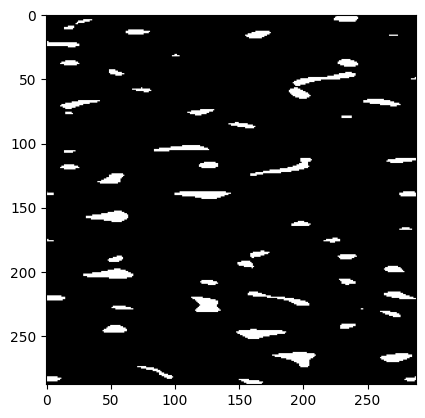

In [109]:
threshold = 0.5
mask_noise = np.where(perlin_noise > threshold, np.ones_like(perlin_noise), np.zeros_like(perlin_noise))

plt.imshow(mask_noise, cmap='gray')

## generate mask

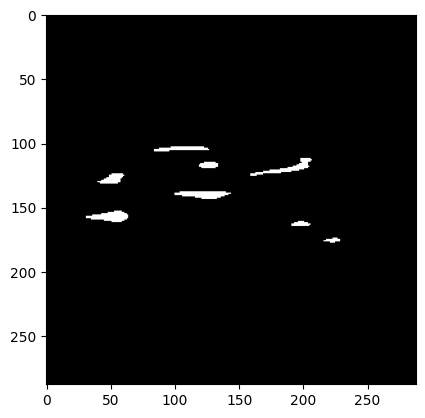

In [110]:
mask = mask_noise * mask_target_foreground
mask = np.expand_dims(mask, axis=2)
plt.imshow(mask, cmap='gray')

# Step 2: Generate Texture or Structure Anomaly

## Texture

- **texture**: load DTD

In [55]:
# texture_source_file_list = glob(os.path.join(cfg['DATASET']['texture_source_dir'],'*/*'))

In [56]:
# # Assuming cfg is a dictionary containing your configurations
# texture_source_dir = cfg['DATASET']['texture_source_dir']

# # Use glob to get all image files in all subdirectories
# texture_source_file_list = glob(os.path.join(texture_source_dir, '**', '*.*'), recursive=True)

# # Filter the list to include only image files with common extensions
# valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
# texture_source_file_list = [f for f in texture_source_file_list if f.lower().endswith(valid_extensions)]

In [57]:
# texture_source_file_list

In [111]:
# Assuming cfg is a dictionary containing your configurations
texture_source_dir = cfg['DATASET']['texture_source_dir']
texture_source_file_list = glob(os.path.join(texture_source_dir, '*', '*.*'))

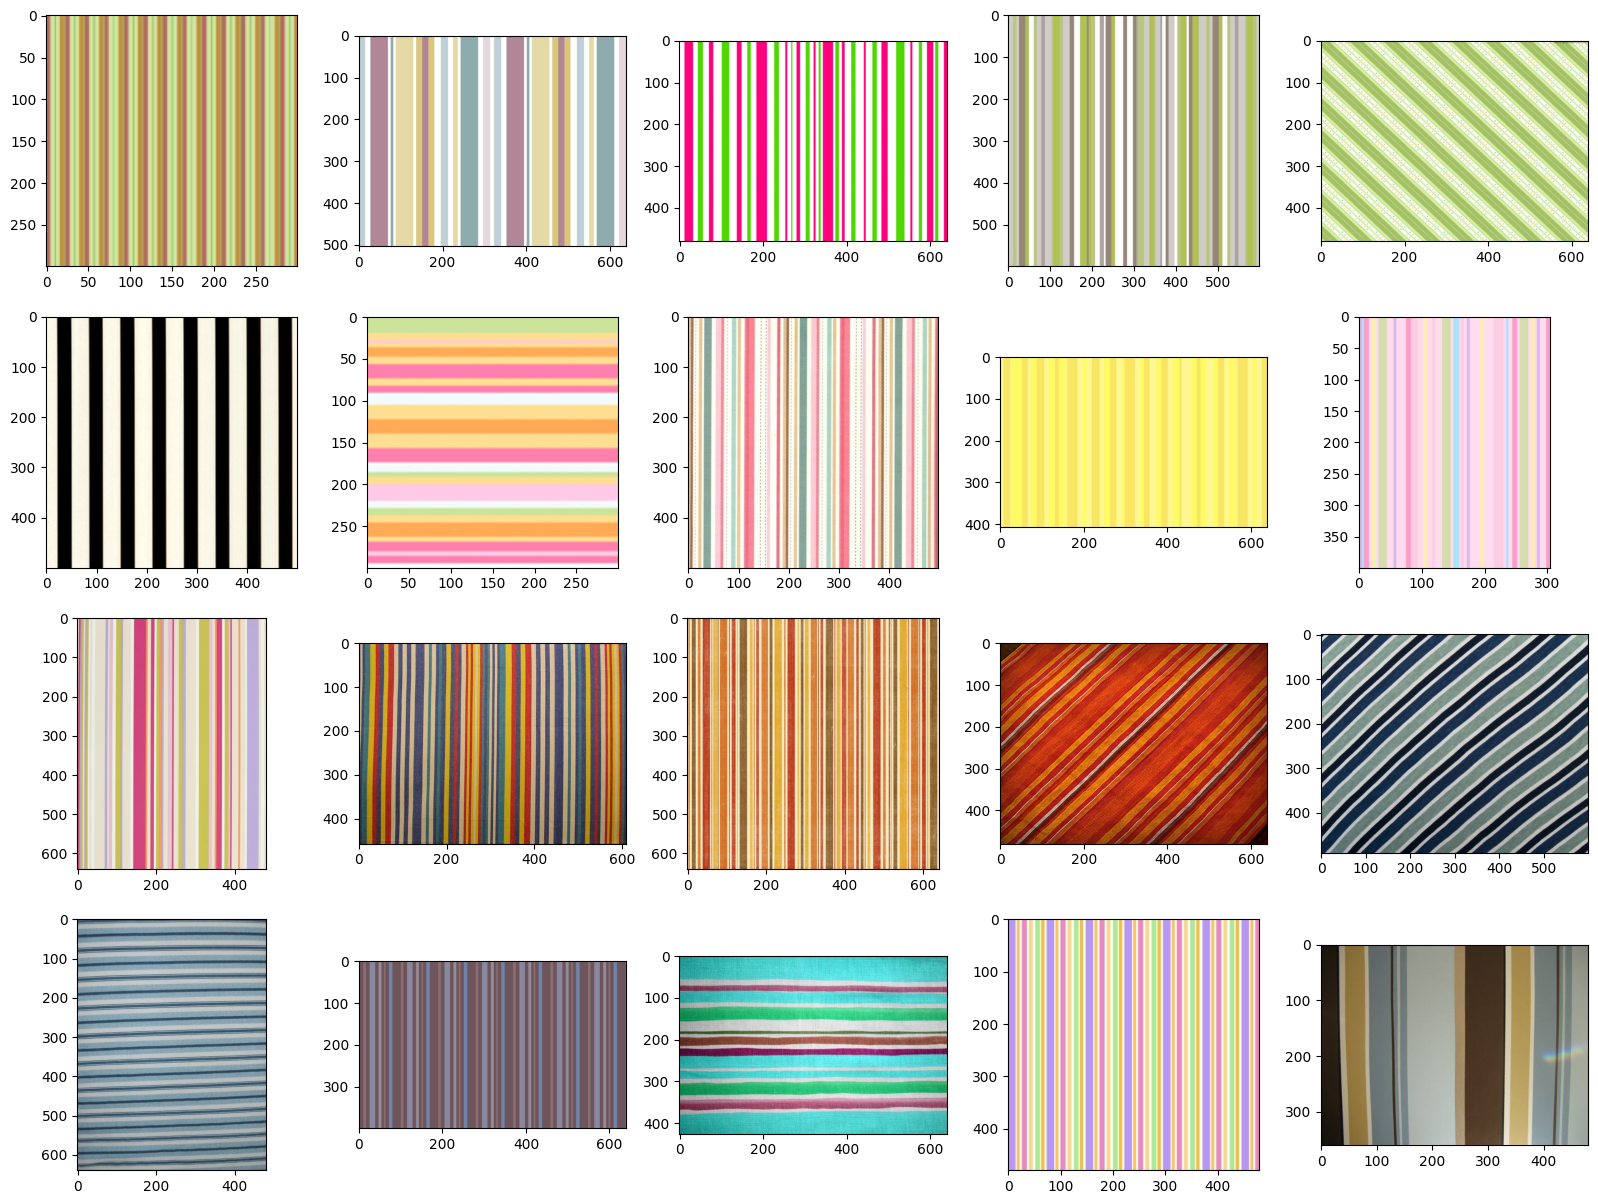

In [112]:
fig, ax = plt.subplots(4,5, figsize=(20,15))

for i in range(4*5):
    texture_source_img = cv2.imread(texture_source_file_list[i])
    if texture_source_img is None:
        print(f"Error: Unable to load image at {texture_source_file_list[i]}")
        continue  # Skip to the next iteration if the image can't be loaded
    texture_source_img = cv2.cvtColor(texture_source_img, cv2.COLOR_BGR2RGB)
    ax[i//5, i%5].imshow(texture_source_img)

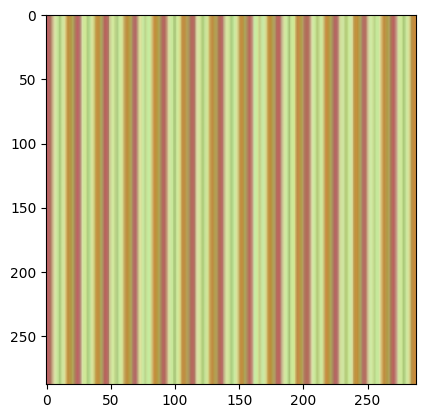

In [113]:
texture_source_img = cv2.imread(texture_source_file_list[0])
texture_source_img = cv2.cvtColor(texture_source_img, cv2.COLOR_BGR2RGB)
texture_source_img = cv2.resize(
    texture_source_img, 
    dsize=(cfg['DATASET']['resize'][1], cfg['DATASET']['resize'][0])
).astype(np.float32)
plt.imshow(texture_source_img.astype(np.uint8))

## Structure

**structure**: we first perform random adjustment of mirror symmetry, rotation, brightness, saturation, and hue on the input image $I$. Then the preliminary processed image is uniformly divided into a 4×8 grid and randomly arranged to obtain the disordered image $I$

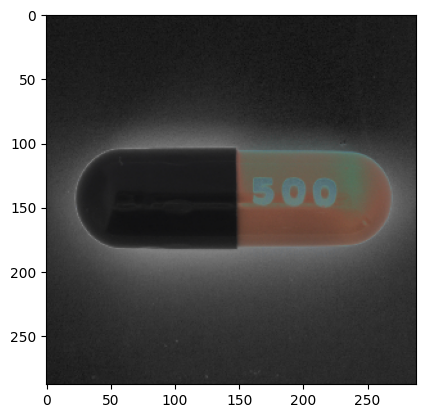

In [154]:
# https://github.com/VitjanZ/DRAEM/blob/main/data_loader.py

augmenters = [
    iaa.GammaContrast((0.5,2.0),per_channel=True),
    iaa.MultiplyAndAddToBrightness(mul=(0.8,1.2),add=(-30,30)),
    iaa.pillike.EnhanceSharpness(),
    iaa.AddToHueAndSaturation((-50,50),per_channel=True),
    iaa.Solarize(0.5, threshold=(32,128)),
    iaa.Posterize(),
    iaa.Invert(),
    iaa.pillike.Autocontrast(),
    iaa.pillike.Equalize(),
    iaa.Affine(rotate=(-45, 45))
]

aug_ind = np.random.choice(np.arange(len(augmenters)), 3, replace=False)
aug = iaa.Sequential([
    augmenters[aug_ind[0]],
    augmenters[aug_ind[1]],
    augmenters[aug_ind[2]]
])

structure_source_img = aug(image=img)
plt.imshow(structure_source_img)

In [155]:
structure_source_img.shape

(288, 288, 3)

In [156]:
cfg['DATASET']['structure_grid_size']

8

In [157]:
assert cfg['DATASET']['resize'][0] % cfg['DATASET']['structure_grid_size'] == 0,  \
        'structure should be devided by grid size accurately'
grid_w = cfg['DATASET']['resize'][1] // cfg['DATASET']['structure_grid_size']
grid_h = cfg['DATASET']['resize'][0] //  cfg['DATASET']['structure_grid_size']

In [158]:
#First Rearrangement: Converts the tensor from a grid-based layout to a flattened grid layout where images are ordered sequentially.
#Shuffling: Randomizes the order of the images to ensure varied input.
#Second Rearrangement: Converts the tensor back to its original grid-based layout but with the images shuffled.

# h and w are the height and width of the grid.
# gh and gw are the height and width of the grid cells.
structure_source_img = rearrange(
    tensor  = structure_source_img, 
    pattern = '(h gh) (w gw) c -> (h w) gw gh c',
    gw      = grid_w, 
    gh      = grid_h
) 
print("new shape is" )
print(structure_source_img.shape)
disordered_idx = np.arange(structure_source_img.shape[0]) 
# (h*w) is reutrn of  the structure_source_img.shape[0]
np.random.shuffle(disordered_idx)

structure_source_img = rearrange(
    tensor  = structure_source_img[disordered_idx], 
    pattern = '(h w) gw gh c -> (h gh) (w gw) c',
    h       = cfg['DATASET']['structure_grid_size'],
    w       = cfg['DATASET']['structure_grid_size']
).astype(np.float32)
# input  (h w) gw gh c where h and w are now dimensions of the flattened grid, and gw, gh, and c are preserved.
# you are rturning image to as it was after shuffeling is by the disorder idx
# output is : (h gh) (w gw) c where the grid dimensions are restored to their original structure.

new shape is
(64, 36, 36, 3)


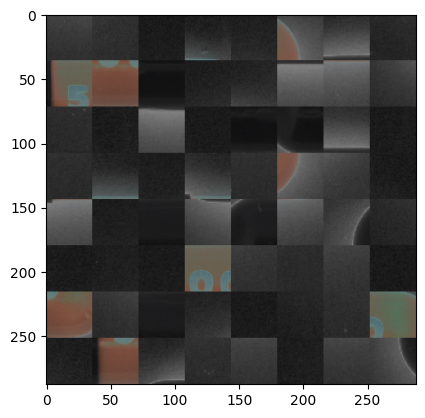

In [159]:
plt.imshow(structure_source_img.astype(np.uint8))

## Result

$$I'_n = \delta(M ⊙ I_n) + (1-\delta)(M ⊙ I)$$

- $M$: mask
- $I$: image
- $\delta$: transparency factor
- $I_n$: anomaly source

In [65]:
factor = np.random.uniform(
    cfg['DATASET']['transparency_range'][0], 
    cfg['DATASET']['transparency_range'][1], 
    size=1
)[0]

In [66]:
print('factor: ',factor)

factor:  0.9232131900985712


In [160]:
texture_source_img = factor * (mask * texture_source_img) + (1 - factor) * (mask * img)

In [161]:
structure_source_img = factor * (mask * structure_source_img) + (1 - factor) * (mask * img)

Text(0.5, 1.0, 'structure')

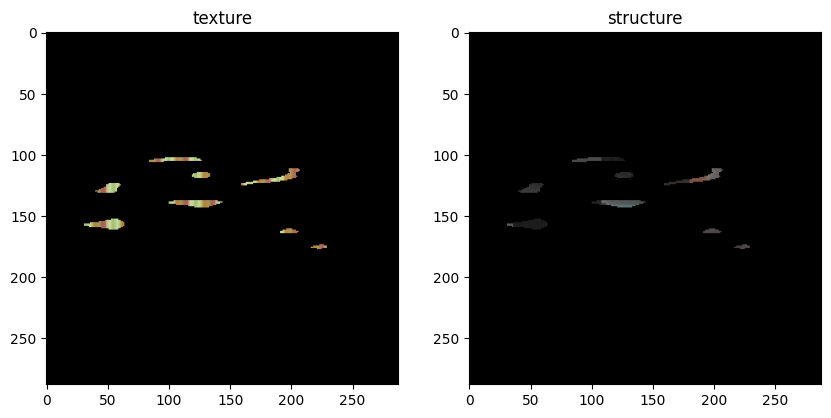

In [162]:
fig, ax = plt.subplots(1,2, figsize=(10,15))
ax[0].imshow(texture_source_img.astype(np.uint8))
ax[0].set_title('texture')
ax[1].imshow(structure_source_img.astype(np.uint8))
ax[1].set_title('structure')

# Step 3. Blending image and anomaly source

$$I_A = \bar{M} ⊙ I + I'_n$$

- $\bar{M}$: inverted mask

In [163]:
texture_anomaly = ((- mask + 1) * img) + texture_source_img
structure_anomaly = ((- mask + 1) * img) + structure_source_img

Text(0.5, 1.0, 'structure anomaly')

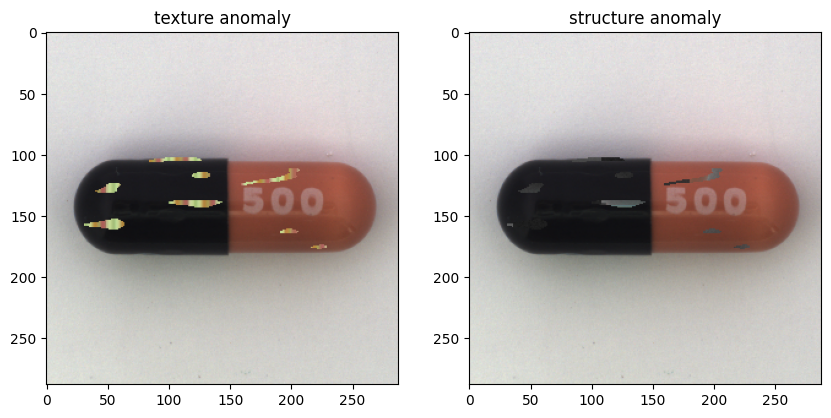

In [164]:
fig, ax = plt.subplots(1,2, figsize=(10,15))
ax[0].imshow(texture_anomaly.astype(np.uint8))
ax[0].set_title('texture anomaly')
ax[1].imshow(structure_anomaly.astype(np.uint8))
ax[1].set_title('structure anomaly')